# Structural Topic Model (STM)

##### Author information
- **Name:** Jaeseong Choe

- **email address:** 21900759@handong.ac.kr

- **GitHub:** https://github.com/sorrychoe

- **Linkedin:** https://www.linkedin.com/in/jaeseong-choe-048639250/

- **Personal Webpage:** https://jaeseongchoe.vercel.app/

## Part 1. Brief background of methodology

### Overview

- **Structural Topic Model(STM) incorporates document-level metadata into the topic modeling process**. 

- It allows **the inclusion of external information (metadata) to influence the document's topic distribution**.


### Situation Before STM

- Topic models like LDA treat documents independently and ignore document-specific covariates.

### Why STM Was Introduced

- STM was introduced from the paper *"A model of text for experimentation in the social sciences."* of Roberts, M. E., Stewart, B. M., & Airoldi, E. M. (2016).

- STM allows for incorporating document-level metadata (e.g., author, date) to influence topic discovery.

### Use Cases

- STM is useful for analyzing how different factors (e.g., authorship, political affiliation) affect topic prevalence.

## Part 2. Key concept of methodology

### Key Concept

- STM incorporates metadata as a covariate affecting the topic distribution, allowing document-specific factors to influence topic discovery.

## Mathematical Formulation

In STM, the probability distribution is:

$$ P(w_{dn}, z_{dn} | X_d, \theta_d, \phi) = P(z_{dn} | X_d, \theta_d) P(w_{dn} | z_{dn}, \phi) $$

*Here, $ X_d $ represents the document metadata, which influences the topic distribution.

### Topic Distribution with Metadata

The topic distribution $ \theta_d $ can be modeled using a logistic normal distribution, where:

$$ \theta_d = \text{softmax}(X_d \beta + \epsilon_d) $$

Here:
- $ X_d $ is the metadata vector for document $d$.
- $ \beta $ represents the regression coefficients.
- $ \epsilon_d $ is a noise term.

### Generative Process

- For each document $d$:
   - Draw a topic distribution $\theta_d$ influenced by metadata $X_d$.
   - For each word $w_{dn}$:
     - Draw a topic $z_{dn} \sim \text{Multinomial}(\theta_d)$.
     - Draw a word $w_{dn} \sim \text{Multinomial}(\phi_{z_{dn}})$.

### Key Assumptions

- Metadata affects the topic distribution.

- The model captures relationships between topics and metadata.

### Strength

- STM captures how external factors affect topic prevalence and topic content.

## Part 3. Example

### Before Sample code

- No library exists that implements stm exactly as the formula stated in the paper in Python. 

- However, there exists in R. Because of this reason, All codes are written in R.

- In this sample code, I use the `stm` package of R

In [1]:
# import librarys
library(stm) # for stm 
library(tidyverse) # for Data preprocessing(dplyr, tidyr), visualization(ggplot2) & use pipeline operator(magrittr)
library(tidytext) # for Text preprocessing
library(tm) # for Text preprocessing
library(showtext) # for set the Korean font
library(readxl) # for load excel data

font_add_google(name = "Nanum Gothic", family = "nanumgothic") # korean font setup
showtext_auto()

stm v1.3.7 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
필요한 패키지를 로딩중입니다: NLP


다음의 패키지를 부착합니다: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


필요한 패키지를 로딩중입니다: sysfonts

필요한 패키지를 로딩중입니다: showtextdb



In [2]:
# data load
# The data is related to Handong University, 
# which was reported in major Korean daily newspapers from January 1995 to September 2024.
df <- read_xlsx("data/NewsResult_19950101-20240930.xlsx")

# data preprocessing
df$키워드 <- gsub(",", " ", df$키워드)

df$Date <- as.Date(df$일자, format = "%Y%m%d")

df$Press <- as.factor(df$언론사)

# Process a vector of raw texts
processed <- textProcessor(documents = df$키워드, metadata = df)

# Prepare documents for analysis
out <- prepDocuments(processed$documents, processed$vocab, processed$meta)

# add meta data at documents
out$meta$Date <- df$Date
out$meta$Press <- df$Press

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 58361 of 98864 terms (58361 of 453771 tokens) due to frequency 
Your corpus now has 8051 documents, 40503 terms and 395410 tokens.

In [3]:
# find proper k value
topicN <- seq(3, 10)
topicN_storage <- searchK(out$documents, out$vocab, K = topicN)

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	...
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.565) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.762, relative change = 8.387e-02) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -8.748, relative change = 1.63

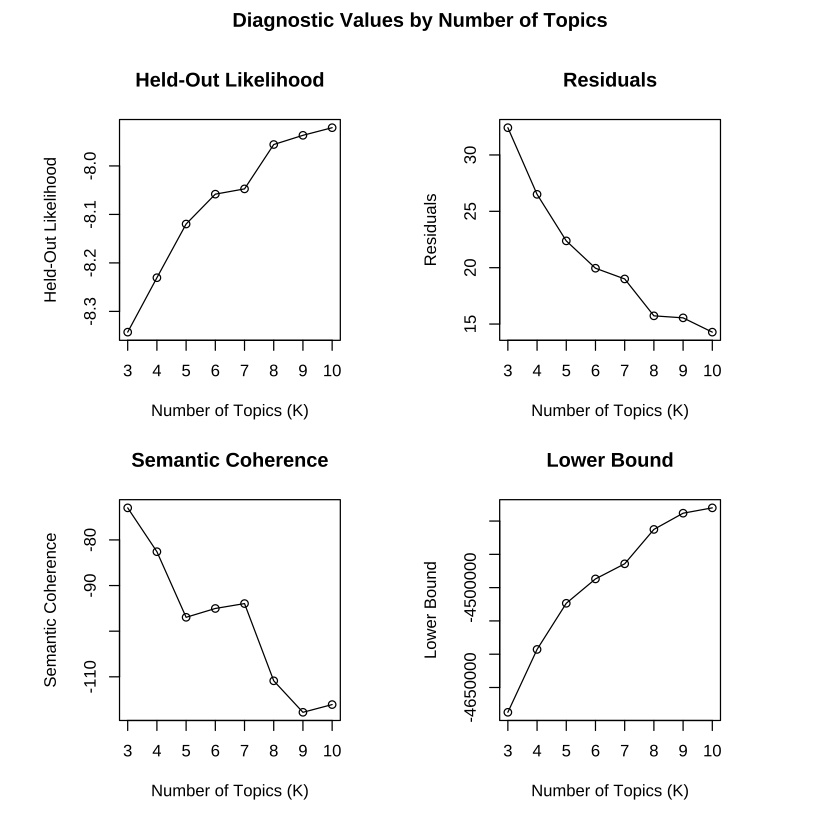

In [4]:
# show result as a plot
# as a result, 7 is the best
plot(topicN_storage)

In [5]:
# define & train the model
stm_model <- stm(documents = out$documents, 
                 vocab = out$vocab, 
                 K = 7, 
                 prevalence = ~ Press + Date, 
                 data = out$meta, 
                 max.em.its = 100, 
                 init.type = "Spectral")

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	.......
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.453) 
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.220, relative change = 1.304e-01) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -7.926, relative change = 

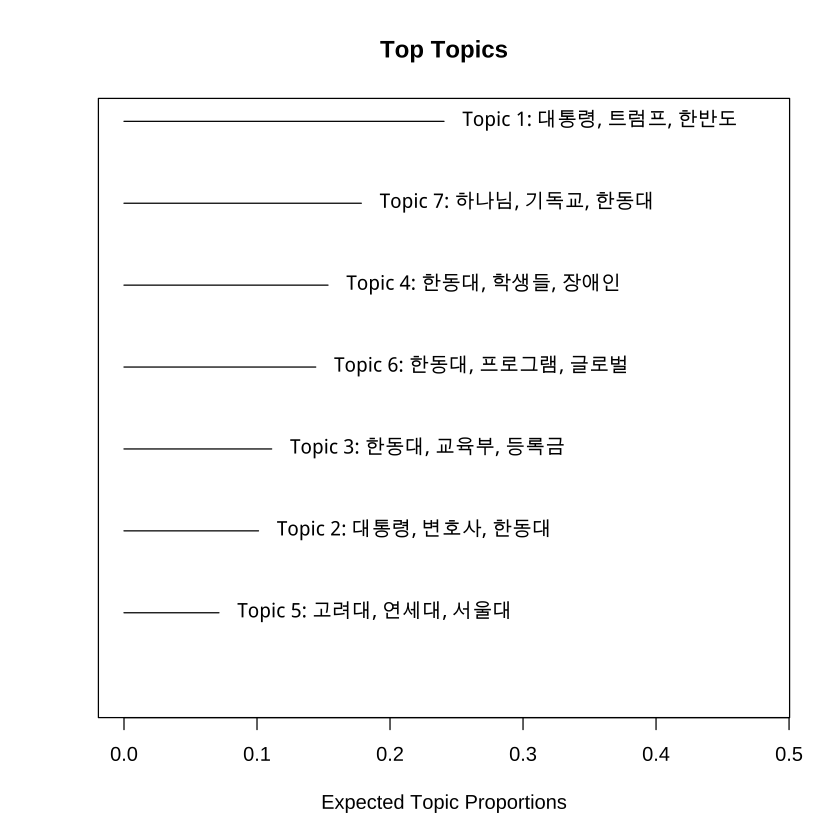

In [6]:
# show result as a plot
plot(stm_model, type = "summary")

In [7]:
# show topic's label
labelTopics(stm_model)

Topic 1 Top Words:
 	 Highest Prob: 대통령, 트럼프, 한반도, 위원장, 가능성, 미사일, 한동대 
 	 FREX: 트럼프, 미사일, 정상회담, 김정은, 비핵화, 방위비, 도널드 
 	 Lift: 가속페달, 가치외교, 각료회의, 갈등요소, 갈등요인, 갈루치, 감소효과 
 	 Score: 트럼프, 비핵화, 미사일, 정상회담, 김정은, 방위비, 대통령 
Topic 2 Top Words:
 	 Highest Prob: 대통령, 변호사, 한동대, 위원회, 로스쿨, 위원장, 이승만 
 	 FREX: 이승만, 대법원, 법률가, 대법원장, 유영익, 교학사, 뉴라이트 
 	 Lift: 갑오경장, 강제송환, 검찰정치, 경수근, 고노담화, 공약들, 광역의원 
 	 Score: 이승만, 변호사, 대통령, 로스쿨, 대법원장, 법률가, 교학사 
Topic 3 Top Words:
 	 Highest Prob: 한동대, 교육부, 등록금, 포항시, 포스텍, 대학들, 글로컬 
 	 FREX: 글로컬, 배터리, 레이저, 글로컬대학, 본지정, 예비지정, 유산균 
 	 Lift: 가스전, 간접피해, 감리교인, 감리사, 감포읍, 강기훈, 강남동 
 	 Score: 글로컬, 등록금, 글로컬대학, 포스텍, 본지정, 포항시, 예비지정 
Topic 4 Top Words:
 	 Highest Prob: 한동대, 학생들, 장애인, 히딩크, 김영길, 부친상, 한동대학교 
 	 FREX: 히딩크, 부친상, 모친상, 서울아산병원, 드림필드, 삼성서울병원, 장인상 
 	 Lift: 간디학교, 간행물, 감상문, 갓페라, 강남성혼, 강남세브란스병원, 강남심포니오케스트라 
 	 Score: 부친상, 히딩크, 모친상, 학생들, 드림필드, 장인상, 서울아산병원 
Topic 5 Top Words:
 	 Highest Prob: 고려대, 연세대, 서울대, 학년도, 학생부, 한양대, 성균관대 
 	 FREX: 학생부, 선문대, 동덕여대, 우수자, 정시모집, 경원대, 특기자 
 	 Lift: 건동대, 경

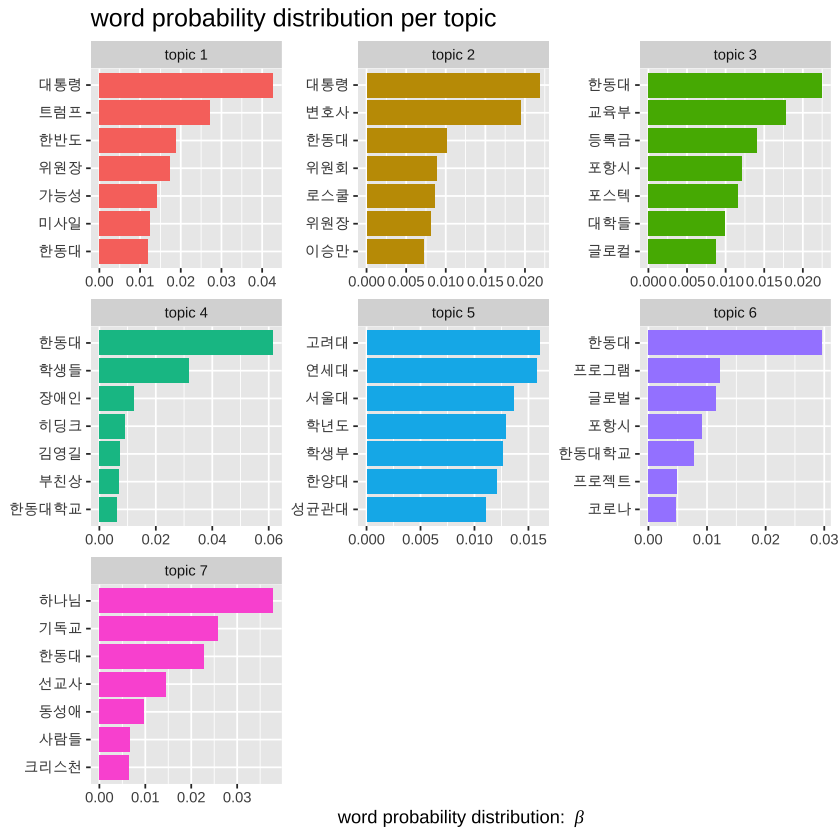

In [8]:
# Tidy the result into a summary data.frame
# Extract the beta value of the topic's probability distribution
td_beta <- stm_model |> tidy(matrix = 'beta') 

# visualization of topic's value
td_beta |>
  group_by(topic) |>
  slice_max(beta, n = 7) |>
  ungroup() |>
  mutate(topic = str_c("topic ", topic)) |>
  ggplot(aes(x = beta, 
             y = reorder_within(term, beta, topic),
             fill = topic)) +
  geom_col(show.legend = F) +
  scale_y_reordered() +
  facet_wrap(~topic, scales = "free") +
  labs(x = expression("word probability distribution: "~beta), y = NULL,
       title = "word probability distribution per topic") +
  theme(plot.title = element_text(size = 15))

### The result of Topic Modeling 

- Topic #1: Topic related to international politics

- Topic #2: Topic related to the law and Handong University

- Topic #3: Topic related to educational performance of Handong University

- Topic #4: Topic related to Donationion with Handong University

- Topic #5: Topic related to college entrance with Handong University

- Topic #6: Topic related to Globalization with Handong University

- Topic #7: Topic related to Christianity at Handong University